# IEA Wind Task 55

This notebook applies *OptiWindNet* to design collector system networks for the two offshore wind plants described in the *IEA Wind TCP Task 55* report (740 MW, 10 MW turbines). Using both regular and irregular turbine layouts in WindIO format, we use `HGSRouter` for warmstarting and `MILPRouter` (OR-Tools solver) for final optimization.

For more info about *IEA Wind TCP Task 55: The IEA Wind 740-10-MW Reference Offshore Wind Plants* read: <https://www.osti.gov/biblio/2333634/>

## Load required data

### Import required modules

In [1]:
import numpy as np
from optiwindnet.api import WindFarmNetwork, HGSRouter, MILPRouter, ModelOptions

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

### Cable data

In [3]:
cables = [(2, 1500.0), (5, 1800.0), (7, 2000.0)]

### Load turbine layouts

Load turbine layouts from WindIO yaml files (Regular and Irregular turbine layouts)

> `WinfFarmNetwork.from_windIO()`is specifically introduced in *OptiWindNet* for WindIO file formats.

In [4]:
wfn_reg = WindFarmNetwork.from_windIO(filepath='data/IEA37_Borssele_Regular_System.yaml', cables=cables)

In [5]:
wfn_irr = WindFarmNetwork.from_windIO(filepath='data/IEA37_Borssele_Irregular_System.yaml', cables=cables)

### Plot locations' geometry.

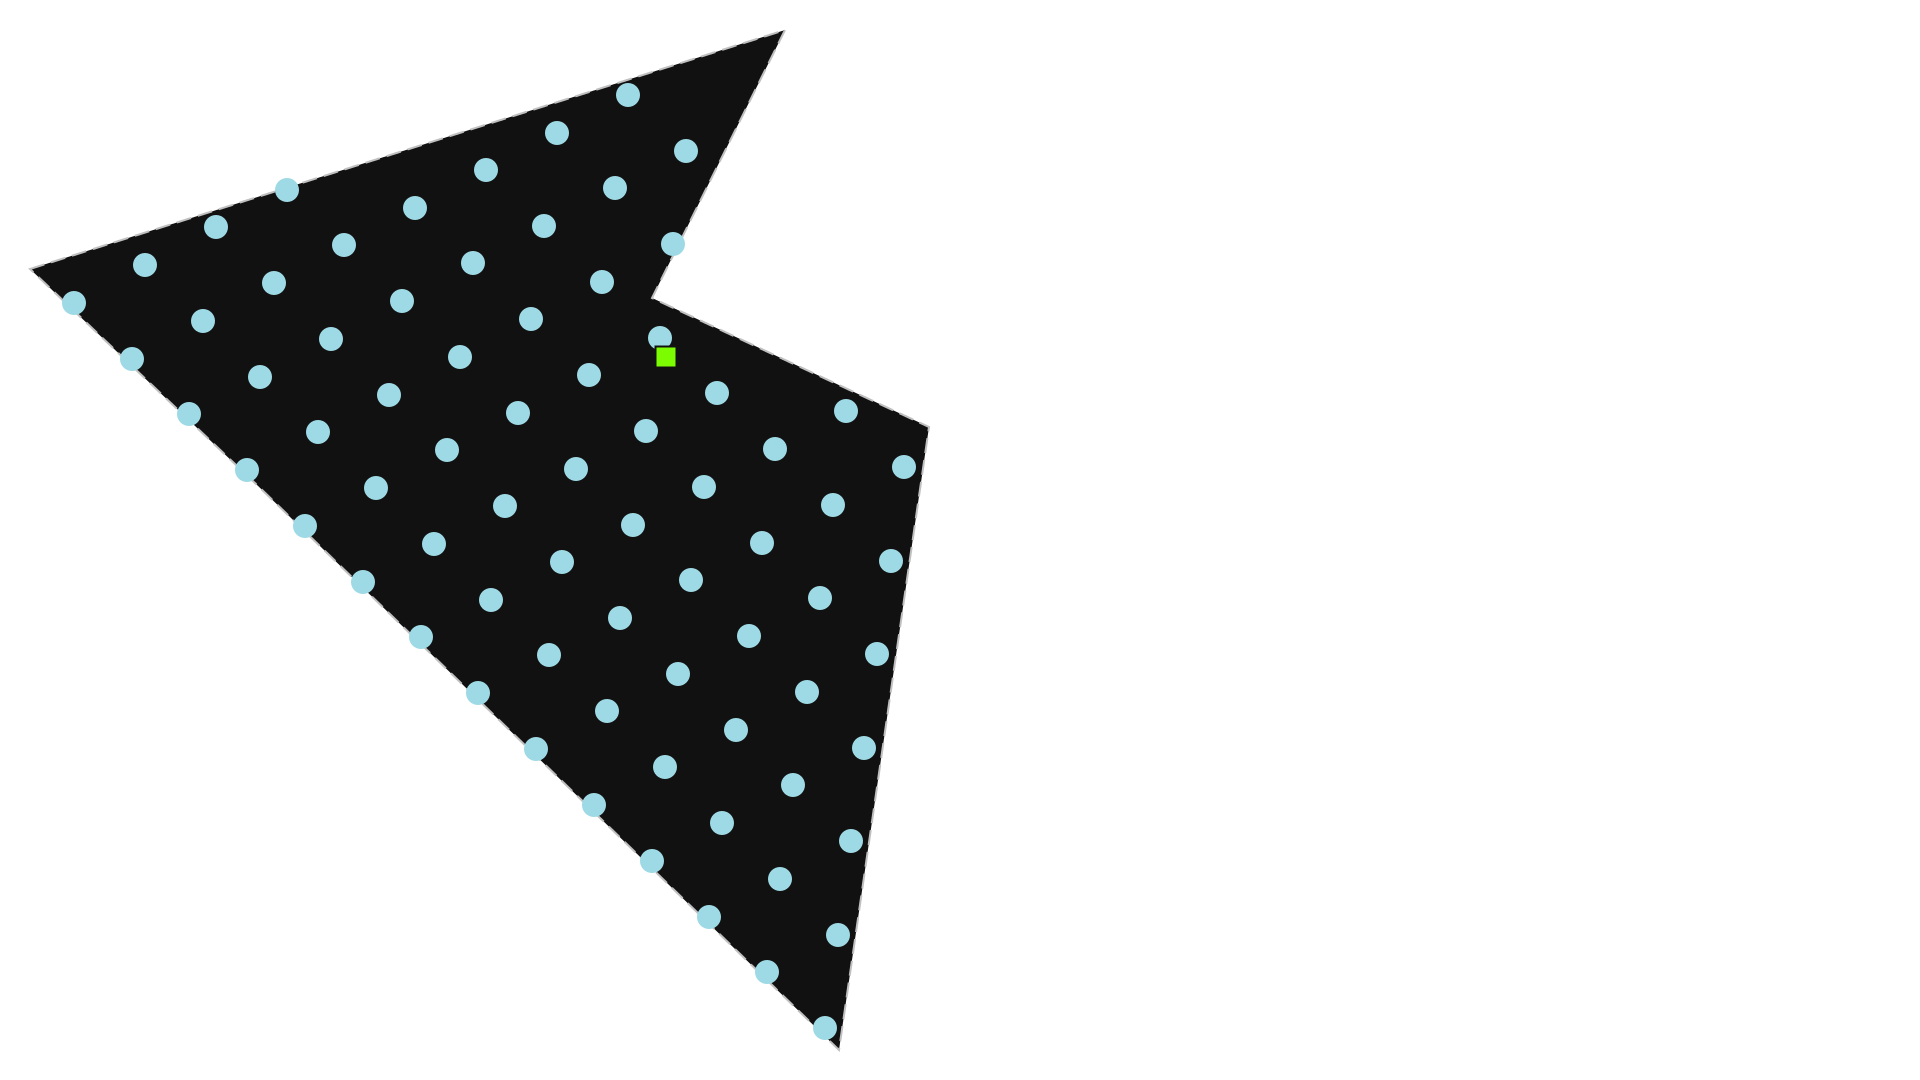

In [6]:
wfn_reg

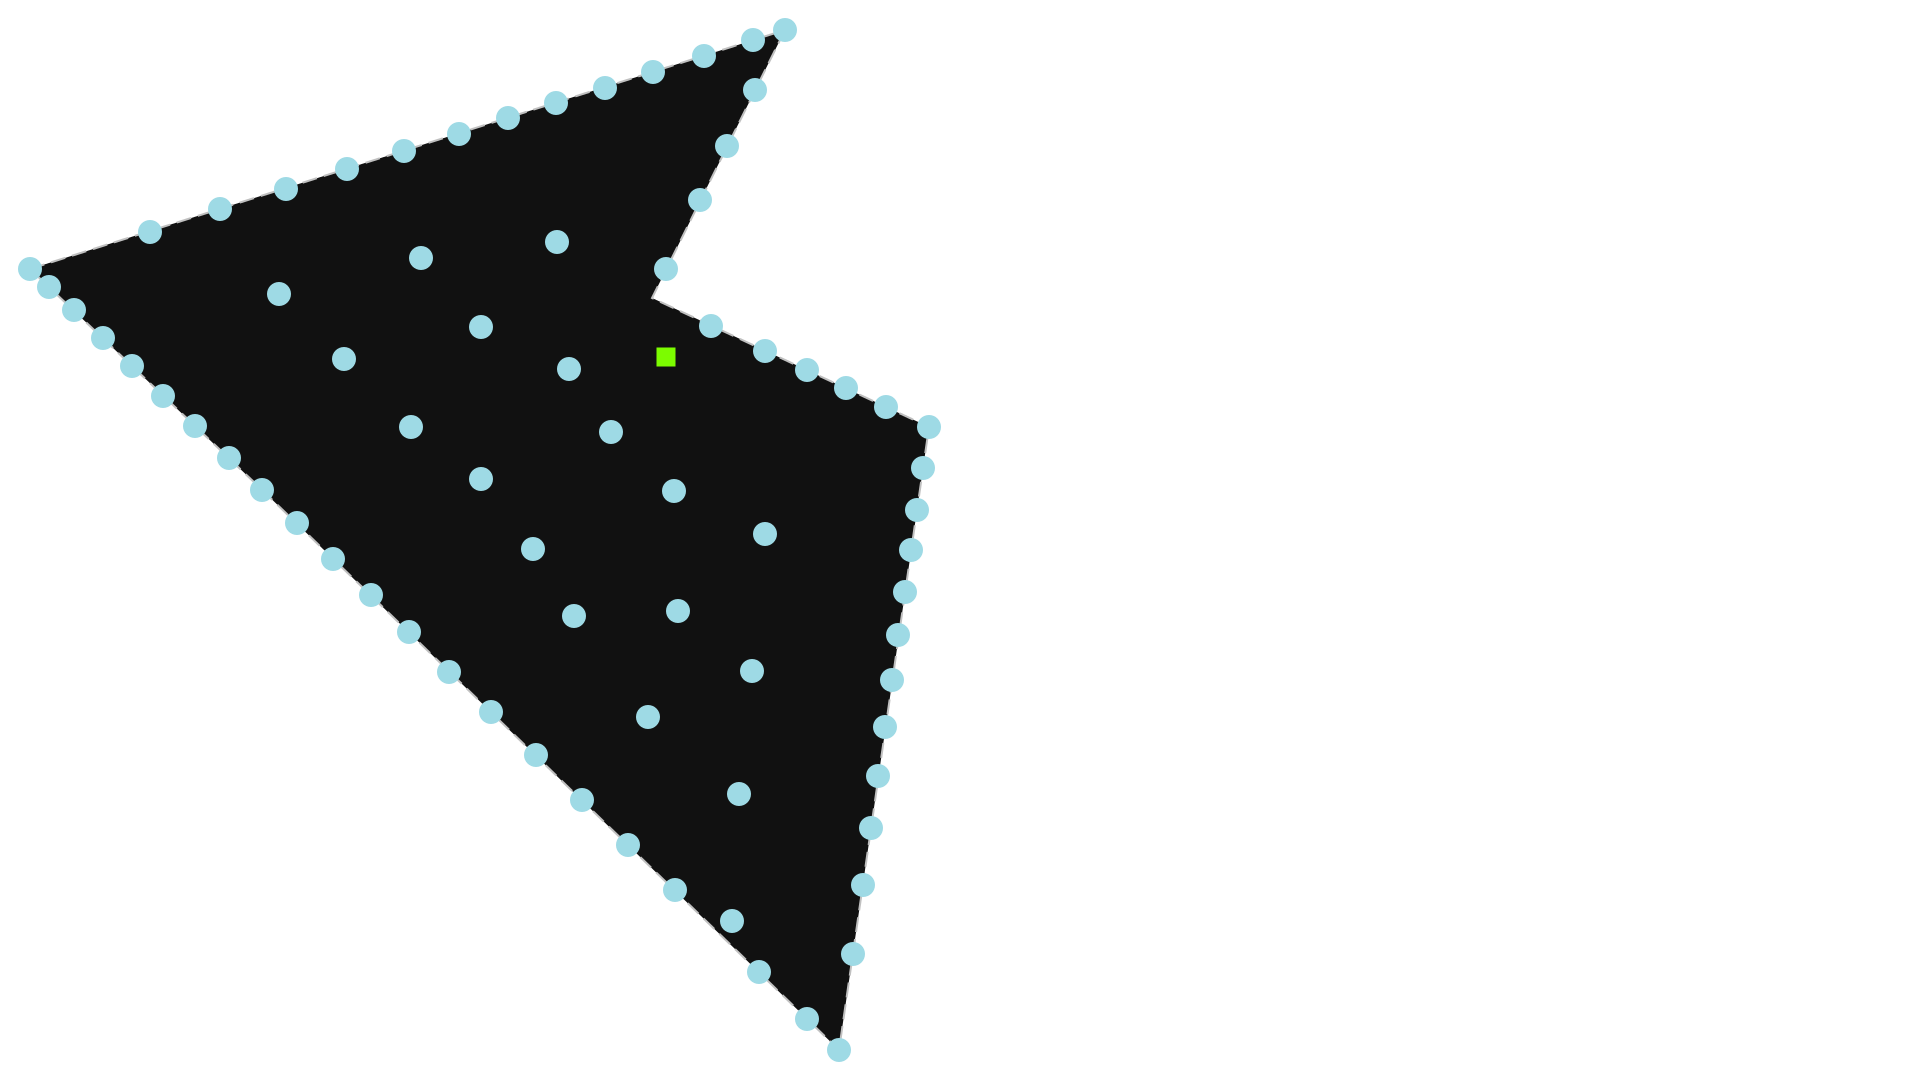

In [7]:
wfn_irr

## Choose the warmstart and main router

In [8]:
warmstart_router = HGSRouter(time_limit=1, verbose=True)

solver_options=dict(
        num_workers = 8,
    )

model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
milp_router = MILPRouter(solver_name='ortools', time_limit=5, mip_gap=0.005, solver_options=solver_options, model_options=model_options, verbose=True)

> For a detailed explanation about model_options and solver_options of MILP routers see [Model Options](a08_ModelOptions.ipynb) and [OR-Tools example](b03_MILPRouter.ipynb) Notebooks.

## Regular turbine layout

### Warmstart

In [9]:
res_reg_warm = wfn_reg.optimize(router=warmstart_router)

Check the total length of the warm-start solution:

In [10]:
wfn_reg.length()

139656.4789599965

### Optimize with MILP router

In [11]:
res_reg = wfn_reg.optimize(router=milp_router, verbose=True)

Using warm start: the model is initialized with the provided solution S.


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 5 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model '': (model_fingerprint: 0xa6c6cb685fe1d85a)
#Variables: 1'536 (#bools: 768 in floating point objective) (1'388 primary variables)
  - 768 Booleans in [0,1]
  - 694 in [0,6]
  - 74 in [0,7]
#kAtMostOne: 613 (#literals: 1'918)
#kLinear1: 1'536 (#enforced: 1'536)
#kLinear3: 2
#kLinearN: 223 (#terms: 3'834)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 768 terms with magnitude in [440.736, 14559.3] average = 2868.79
[Scaling] Objective coefficient relative error: 6.70633e-10
[Scaling] Objective worst-case absolute error: 7.704e-05
[Scaling] Objective scaling factor: 1.04858e+06
  4.75e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.25e-02s  0.00e+00d  [operations_research::sat::CpModelPr

In [12]:
wfn_reg.length()

139645.18265364

In [13]:
wfn_reg.cost()

248112330.12342116

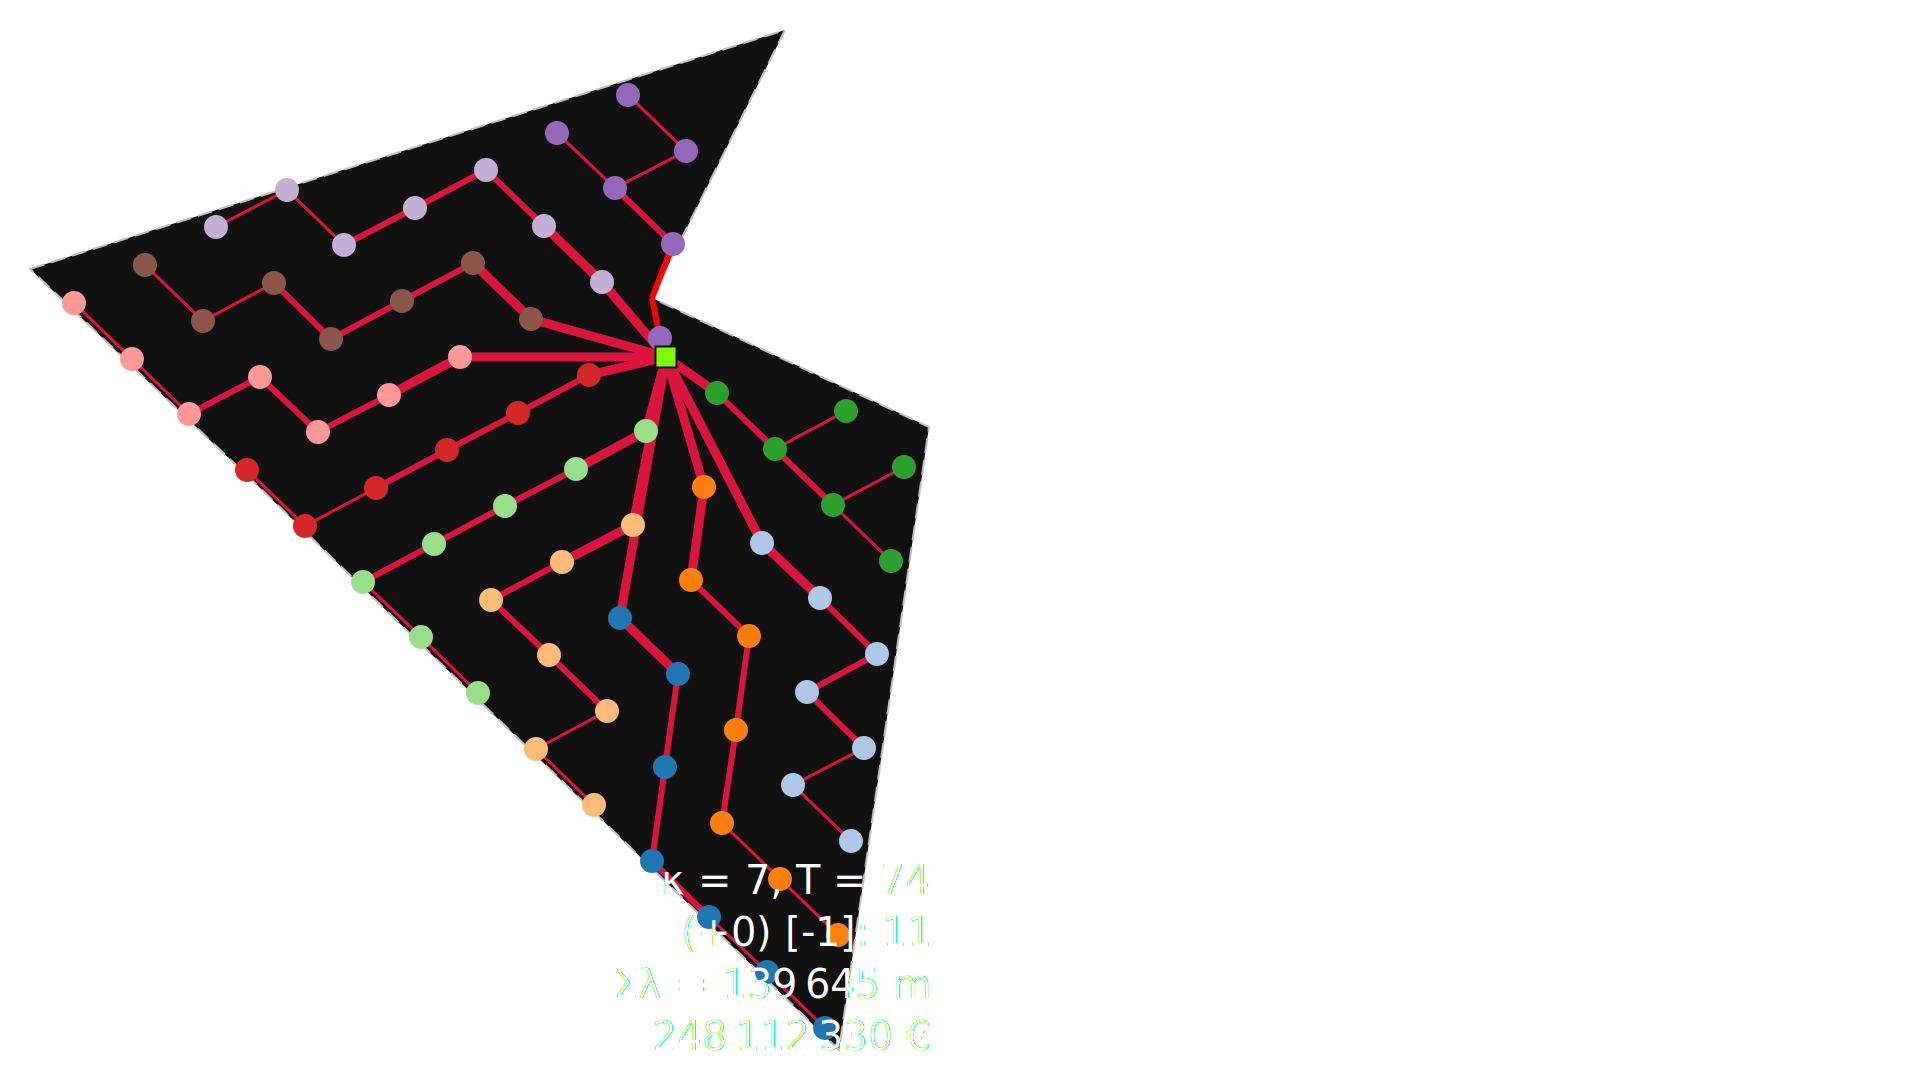

In [14]:
wfn_reg

## Irregular turbine layout

In [15]:
res_irr_warmup = wfn_irr.optimize(router=warmstart_router)

Check the total length of the warm-start solution:

In [16]:
wfn_irr.length()

136472.2480500915

### Optimize with MILP router

In [17]:
res_irr = wfn_irr.optimize(router=milp_router)

Using warm start: the model is initialized with the provided solution S.


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 5 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model '': (model_fingerprint: 0xdce7638cf32cc953)
#Variables: 1'192 (#bools: 596 in floating point objective) (1'044 primary variables)
  - 596 Booleans in [0,1]
  - 522 in [0,6]
  - 74 in [0,7]
#kAtMostOne: 419 (#literals: 1'216)
#kLinear1: 1'192 (#enforced: 1'192)
#kLinear2: 4
#kLinear3: 5
#kLinearN: 216 (#terms: 2'957)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 596 terms with magnitude in [539.378, 15073.7] average = 3460.13
[Scaling] Objective coefficient relative error: 4.51281e-10
[Scaling] Objective worst-case absolute error: 7.28067e-05
[Scaling] Objective scaling factor: 1.04858e+06
  1.21e-03s  0.00e+00d  [DetectDominanceRelations] 
  1.01e-02s  0.00e+00d  [operations_research:

In [18]:
wfn_irr.length()

134807.7634895362

In [19]:
wfn_irr.cost()

247033944.13135293

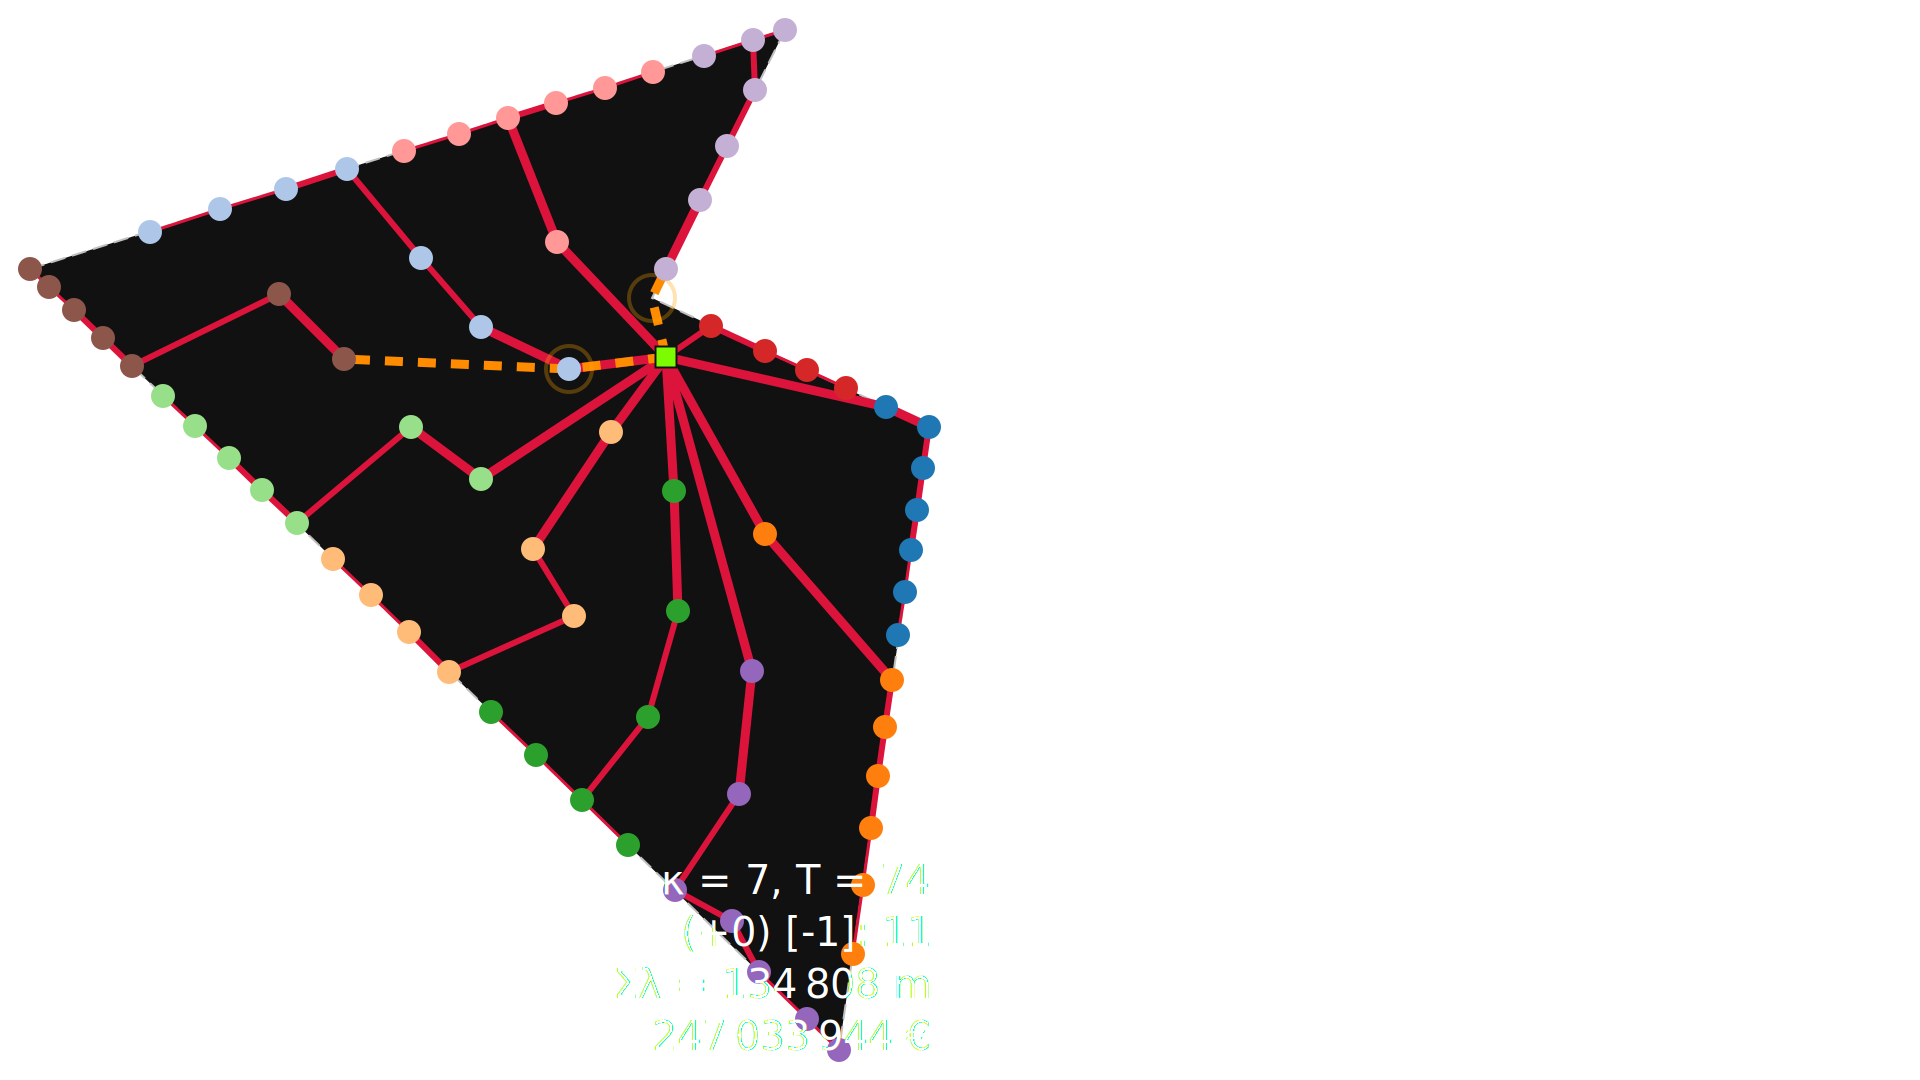

In [20]:
wfn_irr

## Layouts' edge list

These lists of 3-tuples has all the edges and their cable type (as an index to the `turbines_per_cable` list), i.e. (coordinate_A, coordinate_B, cable_type).

Negative node indices represent substations, the node indices ranging from 0 to 73 represent the WT in the order they were given.

If the network has contours or detours, indices will go beyond the number of coordinates (WT, SS, borders) provided, and the mapping of these additional indices to indices to the provided coordinates is presented.

In [21]:
wfn_reg.G.edges(data='cable')

EdgeDataView([(-1, 47, 2), (-1, 56, 2), (-1, 46, 2), (-1, 33, 2), (-1, 45, 2), (-1, 57, 2), (-1, 34, 2), (-1, 24, 2), (-1, 49, 2), (-1, 58, 2), (-1, 32, 2), (0, 1, 0), (1, 4, 0), (4, 5, 1), (2, 3, 0), (3, 8, 0), (8, 14, 1), (5, 9, 1), (9, 15, 1), (6, 7, 0), (7, 12, 0), (12, 13, 1), (14, 22, 1), (15, 24, 2), (10, 11, 0), (11, 16, 0), (16, 17, 1), (13, 20, 1), (20, 21, 1), (22, 23, 1), (17, 26, 1), (26, 25, 1), (18, 19, 0), (19, 28, 0), (28, 27, 1), (21, 32, 2), (23, 33, 2), (25, 34, 2), (27, 36, 1), (36, 35, 1), (29, 38, 0), (29, 40, 0), (38, 37, 1), (30, 31, 0), (31, 44, 1), (31, 42, 0), (44, 45, 1), (44, 43, 0), (35, 46, 2), (37, 48, 1), (48, 47, 1), (39, 50, 1), (39, 52, 1), (50, 49, 2), (41, 52, 1), (41, 54, 0), (51, 62, 1), (51, 60, 1), (60, 59, 1), (53, 62, 0), (53, 64, 0), (61, 70, 0), (61, 69, 1), (69, 68, 1), (63, 70, 0), (54, 55, 0), (65, 66, 1), (65, 80, 1), (56, 80, 1), (67, 68, 1), (67, 57, 2), (59, 58, 2), (66, 71, 0), (66, 73, 0), (71, 72, 0)])

Alternatively we can use `get_network()` method, to get the final cabling network as a structured array of edge data, and then extract desired edge data from it.

### Regular turbine layout

In [22]:
network_reg = wfn_reg.get_network()
print(network_reg.dtype.names)

('src', 'tgt', 'length', 'load', 'cable')


In [23]:
network_cable_reg = np.column_stack((network_reg['src'], network_reg['tgt'], network_reg['cable']))
print(network_cable_reg)

[[47 -1  2]
 [56 -1  2]
 [46 -1  2]
 [33 -1  2]
 [45 -1  2]
 [57 -1  2]
 [34 -1  2]
 [24 -1  2]
 [49 -1  2]
 [58 -1  2]
 [32 -1  2]
 [ 0  1  0]
 [ 1  4  0]
 [ 4  5  1]
 [ 2  3  0]
 [ 3  8  0]
 [ 8 14  1]
 [ 5  9  1]
 [ 9 15  1]
 [ 6  7  0]
 [ 7 12  0]
 [12 13  1]
 [14 22  1]
 [15 24  2]
 [10 11  0]
 [11 16  0]
 [16 17  1]
 [13 20  1]
 [20 21  1]
 [22 23  1]
 [17 26  1]
 [26 25  1]
 [18 19  0]
 [19 28  0]
 [28 27  1]
 [21 32  2]
 [23 33  2]
 [25 34  2]
 [27 36  1]
 [36 35  1]
 [29 38  0]
 [40 29  0]
 [38 37  1]
 [30 31  0]
 [31 44  1]
 [42 31  0]
 [44 45  1]
 [43 44  0]
 [35 46  2]
 [37 48  1]
 [48 47  1]
 [39 50  1]
 [52 39  1]
 [50 49  2]
 [41 52  1]
 [54 41  0]
 [62 51  1]
 [51 60  1]
 [60 59  1]
 [53 62  0]
 [64 53  0]
 [70 61  0]
 [61 69  1]
 [69 68  1]
 [63 70  0]
 [55 54  0]
 [66 65  1]
 [65 80  1]
 [80 56  1]
 [68 67  1]
 [67 57  2]
 [59 58  2]
 [71 66  0]
 [73 66  0]
 [72 71  0]]


### Irregular turbine layout

In [24]:
network_irr = wfn_irr.get_network()
network_cable_irr = np.column_stack((network_irr['src'], network_irr['tgt'], network_irr['cable']))
print(network_cable_irr)

[[41 -1  2]
 [28 -1  2]
 [49 -1  2]
 [55 -1  1]
 [39 -1  2]
 [60 -1  2]
 [70 -1  2]
 [25 -1  2]
 [33 -1  2]
 [80 -1  2]
 [81 -1  2]
 [ 0 50  0]
 [50 46  0]
 [ 1 34  0]
 [34 20  0]
 [ 2  8  1]
 [ 7  2  1]
 [ 8 42  1]
 [ 3 12  1]
 [15  3  1]
 [12 45  1]
 [ 4 20  0]
 [20 37  1]
 [ 9  5  0]
 [ 5 32  1]
 [32 14  1]
 [ 6 35  0]
 [35 36  0]
 [42 25  2]
 [10 24  0]
 [24 17  0]
 [11 18  0]
 [18 59  0]
 [45 33  2]
 [13 26  0]
 [26 31  0]
 [14 68  1]
 [68 73  2]
 [16 29  1]
 [17 16  1]
 [29 53  1]
 [59 60  2]
 [52 59  1]
 [37 51  1]
 [44 22  1]
 [22 67  1]
 [67 70  2]
 [23 43  0]
 [43  7  0]
 [31 56  1]
 [27 52  0]
 [38 27  0]
 [53 28  2]
 [30 54  1]
 [56 30  1]
 [54 49  2]
 [36 62  1]
 [62 69  1]
 [51 41  2]
 [40 55  1]
 [57 40  0]
 [47 65  0]
 [65 58  1]
 [48 65  0]
 [58 61  1]
 [61 64  1]
 [64 71  2]
 [69 63  1]
 [71 81  2]
 [73 80  2]
 [21 15  0]
 [19  9  0]
 [66 21  0]
 [46 44  1]
 [63 39  2]
 [72 57  0]]


## Mapping of contour/detour

Mapping of contour/detour node to the index of its VertexC coordinate :

In [25]:
wfn_reg.map_detour_vertex()

{80: 76}

In [26]:
wfn_irr.map_detour_vertex()

{80: 28, 81: 76}